In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

Dataloaders created with the help of: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [2]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=64),
        A.RandomCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
train_data_path = 'generated_artillery/train' 
test_data_path = 'generated_artillery/test'

train_image_paths = []

for data_path in glob.glob(train_data_path + '/*'):
    train_image_paths.append(data_path)
    data_path = data_path.replace(train_data_path, '')
    
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]
    
test_image_paths = []

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)
    data_path = data_path.replace(test_data_path, '')

In [4]:
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 2560
Valid size: 640
Test size: 800


In [5]:
class SymbolDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = 1 if image_filepath.split('_')[-1].split('.')[0] == 'artillery' else 0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

train_dataset = SymbolDataset(train_image_paths,transforms)
valid_dataset = SymbolDataset(valid_image_paths,transforms)
test_dataset = SymbolDataset(test_image_paths,transforms)

In [6]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False
)

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [9]:
# Code for validation and testing
def test(model, data_loader, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.eval()
    
    for data in data_loader:
        inputs, labels = data
        
        outputs = model(inputs)
        
        preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
        correct += np.sum(preds_bool)
        total += preds_bool.size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
    test_loss = running_loss / len(data_loader)
    test_acc = correct / total

    return test_loss, test_acc

In [10]:
# Code for training the model
train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(1, 41):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = model(inputs)
        
        preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
        correct += np.sum(preds_bool)
        total += preds_bool.size

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    train_acc = correct / total
    train_accs.append(train_acc)
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    val_loss, val_acc = test(model, valid_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} train - loss:', train_loss, 'acc:', train_acc)
        print(f'Epoch {epoch} val - loss:', val_loss, 'acc:', val_acc)
        
        
print('Finished Training')

Epoch 5 train - loss: 0.6014922250062227 acc: 0.79921875
Epoch 5 val - loss: 0.5855474300682545 acc: 0.7859375
Epoch 10 train - loss: 0.2616501963697374 acc: 0.94140625
Epoch 10 val - loss: 0.2349942959845066 acc: 0.9484375
Epoch 15 train - loss: 0.15961825860431417 acc: 0.96171875
Epoch 15 val - loss: 0.16187663031741978 acc: 0.9625
Epoch 20 train - loss: 0.15058130059624092 acc: 0.9640625
Epoch 20 val - loss: 0.14506050157360734 acc: 0.9640625
Epoch 25 train - loss: 0.141782570281066 acc: 0.96328125
Epoch 25 val - loss: 0.14979997179470955 acc: 0.9625
Epoch 30 train - loss: 0.14299289716873317 acc: 0.96328125
Epoch 30 val - loss: 0.14645120657514782 acc: 0.9625
Epoch 35 train - loss: 0.14107366892858408 acc: 0.963671875
Epoch 35 val - loss: 0.14015553444623946 acc: 0.9625
Epoch 40 train - loss: 0.13800951090524904 acc: 0.9640625
Epoch 40 val - loss: 0.13410246442072093 acc: 0.9640625
Finished Training


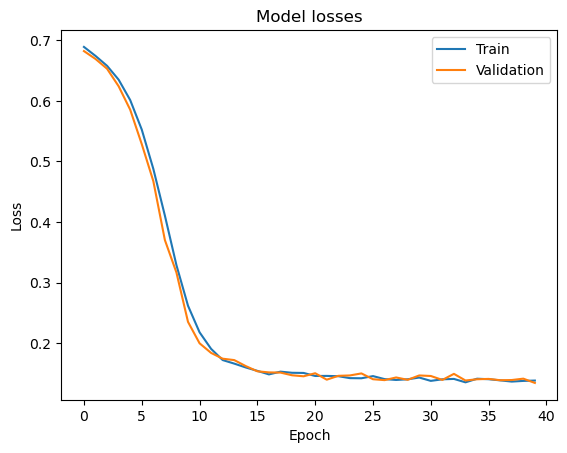

In [11]:
# Model train/val losses
plt.title('Model losses')

plt.plot(train_losses)
plt.plot(val_losses)

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

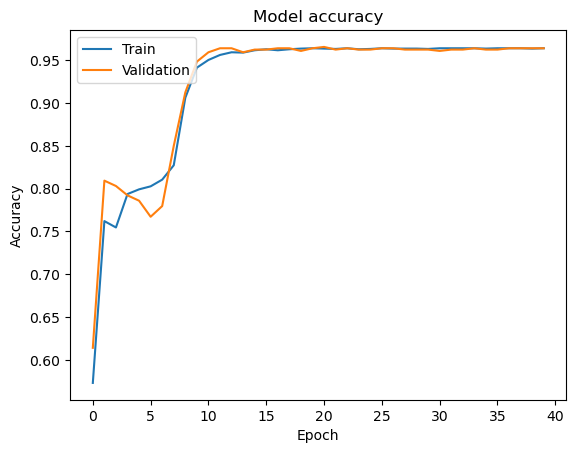

In [12]:
# Model train/val accuracy
plt.title('Model accuracy')

plt.plot(train_accs)
plt.plot(val_accs)

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
test_loss, test_acc = test(model, test_loader, criterion)

In [14]:
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.11740709375590086
Test acc: 0.97125


In [15]:
scripted_model = torch.jit.script(model)
scripted_model.save('models/model_arty.pt')